In [1]:
import pystac_client
import rasterio
import matplotlib.pyplot as plt
from rasterio.coords import BoundingBox
import numpy as np
import h5py
from tqdm import tqdm
from rasterio.windows import from_bounds

As a first step, the Swisstopo dataset is downloaded and processed as time series per forest pixel. Run the code in extract_swisstopo_dataset.py

To be able to visualise a time step from the dataset, we first repeat some of the code to get the mapping to forest pixels on the raster covering Switzerland.

In [3]:
# Connect to Swisstopo STAC API
service = pystac_client.Client.open('https://data.geo.admin.ch/api/stac/v0.9/')
service.add_conforms_to("COLLECTIONS")
service.add_conforms_to("ITEM_SEARCH")

# EPSG: 4326
# WGS 84
# Swiss bounds: left, bottom, right, top
bbox_swiss_4326 = [5.70, 45.8, 10.6, 47.95]

# Retrieve the spatial coverage (bounds) of all 4 possible orbits covering Switzerland
def collect_bounds_all_orbits():
    """
    Collects the bounds of all orbits in the Swiss dataset.
    Returns a list of BoundingBox objects.
    """
    item_search = service.search(
        bbox=bbox_swiss_4326,
        datetime='2025-04-30/2025-05-02',
        collections=['ch.swisstopo.swisseo_s2-sr_v100']
    )
    s2_files_sample_orbits = list(item_search.items())

    all_bounds = []

    for item in tqdm(s2_files_sample_orbits):
        assets = item.assets
        key_bands = [k for k in assets.keys() if k.endswith('bands-10m.tif')][0]
        bands_asset = assets[key_bands]
        with rasterio.open(bands_asset.href) as src:
            bounds = src.bounds
            all_bounds.append(bounds)

    return all_bounds

# Combine all bounding boxes into one global bounding box and compute its pixel dimensions
def union_bounds(bounds_list):
    """
    Takes a list of BoundingBox objects and returns a single BoundingBox
    that encompasses all the bounds, along with the width and height
    of the bounding box in pixels, assuming a resolution of 10 meters.
    """
    left = min(b.left for b in bounds_list)
    bottom = min(b.bottom for b in bounds_list)
    right = max(b.right for b in bounds_list)
    top = max(b.top for b in bounds_list)
    resolution = 10
    width = int((right - left) / resolution)
    height = int((top - bottom) / resolution)
    return BoundingBox(left, bottom, right, top), width, height

all_bounds = collect_bounds_all_orbits()

# EPSG: 2056
# Swiss coordinate system (CH1903+ / LV95)
# This is the full reference bounding box for the Swisstopo dataset covering the 4 orbits
bbox_swisstopo_2056, width_swisstopo, height_swisstopo = union_bounds(all_bounds)

# Derive the forest mask from the Swisstopo VHI dataset 
# The VHI dataset contains the forest mask that Swisstopo derived from the habitat map
# Also collect the metadata using the forest mask as a reference raster
def get_forest_mask():
    """
    Downloads the forest mask from the Swisstopo VHI dataset.
    Returns a numpy array representing the forest mask.
    Also returns the metadata for the reference raster.
    """
    item_search = service.search(
        bbox=bbox_swiss_4326,
        datetime='2025-05-01/2025-05-01',
        collections=['ch.swisstopo.swisseo_vhi_v100']
    )
    items = list(item_search.items())
    item = items[0]
    assets = item.assets
    key_bands = [k for k in assets.keys() if k.endswith('forest-10m.tif')][0]
    bands_asset = assets[key_bands]
    
    with rasterio.open(bands_asset.href) as src:
        window = src.window(*bbox_swisstopo_2056)
        vhi = src.read(1, window=window)
        forest_mask = (vhi != 255).astype('uint8')
        ref_meta = {
            "transform": src.window_transform(window),
            "crs": src.crs,
            "width": window.width,
            "height": window.height
        }
    
    return forest_mask, ref_meta

forest_mask, ref_meta = get_forest_mask()
print("Reference raster metadata:")
print(ref_meta)

# Build index mapping from forest pixels in the full reference raster to 1D flat indices
forest_flat_indices = np.flatnonzero(forest_mask == 1)

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Reference raster metadata:
{'transform': Affine(10.0, 0.0, np.float64(2474090.0),
       0.0, -10.0, np.float64(1310530.0)), 'crs': CRS.from_wkt('PROJCS["CH1903+ / LV95",GEOGCS["CH1903+",DATUM["CH1903+",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6150"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4150"]],PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],PARAMETER["latitude_of_center",46.9524055555556],PARAMETER["longitude_of_center",7.43958333333333],PARAMETER["azimuth",90],PARAMETER["rectified_grid_angle",90],PARAMETER["scale_factor",1],PARAMETER["false_easting",2600000],PARAMETER["false_northing",1200000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2056"]]'), 'width': np.float64(37728.0), 'height': np.float64(24542.0)}


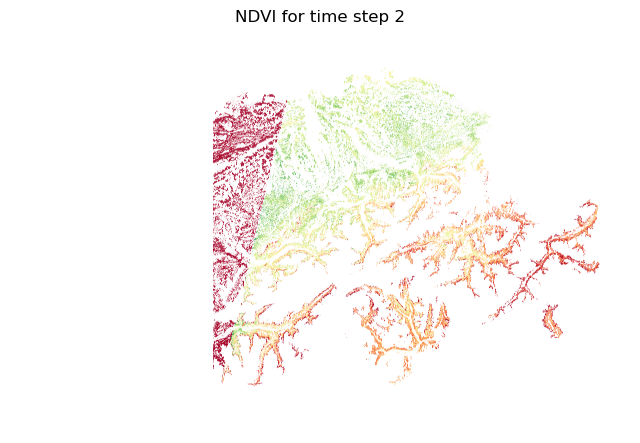

In [ ]:
height = 24542
width = 37728
NDVI_INVALID = -2**15
NDVI_NO_COVERAGE = 2**15 - 1
time_step = 2

ndvi_path = "/data_2/scratch/sbiegel/processed/new_ndvi_timeseries.h5"

with h5py.File(ndvi_path, "r") as h5f:
    # Use indexing to read only one time step
    ndvi_row = h5f["ndvi"][time_step]

is_invalid = ndvi_row == NDVI_INVALID
is_no_coverage = ndvi_row == NDVI_NO_COVERAGE
is_valid = ~(is_invalid | is_no_coverage)

ndvi_rgb = np.ones((height, width, 4), dtype="float32")  # all white (RGBA)

cmap = plt.get_cmap("RdYlGn")
valid_ndvi = ndvi_row[is_valid].astype("float32") / 10000.0

ndvi_vals = np.full((height * width,), np.nan, dtype="float32")
ndvi_vals[forest_flat_indices[is_valid]] = valid_ndvi
ndvi_vals = ndvi_vals.reshape((height, width))

valid_mask = ~np.isnan(ndvi_vals)
ndvi_rgb[valid_mask] = cmap(ndvi_vals[valid_mask])

plt.figure(figsize=(8, 6))
plt.imshow(ndvi_rgb)
plt.title(f"NDVI for time step {time_step}")
plt.axis("off")
plt.show()

### Species map

In [ ]:
tree_species_path = '/data/archive_restricted/treespecies_koch_2024/data_share_FORWARDS/tree_species_map_aoa_raster.tif'
with rasterio.open(tree_species_path) as src:
    tree_species = src.read(1)

plt.imshow(tree_species, cmap='tab20', vmin=1, vmax=20)
plt.colorbar(label='Tree Species')

### Habitat map

In [ ]:
habitat_path = '/data_2/scratch/sbiegel/habitatmap_v1_1_20241025.tif'
with rasterio.open(habitat_path) as src:
    print(src.count)
    print(src.width, src.height)
    print(src.dtypes)
    window = src.window(*bbox_swisstopo_2056)
    print("Window:", window)
    print("Bounds:", src.bounds)
    habitat = src.read(1, 
                    window=window,
                    out_shape=(1, src.height // 10, src.width // 10), 
                    resampling=rasterio.enums.Resampling.mode)


1
348448 220666
('uint16',)
Window: Window(col_off=np.float64(-11320.215000152588), row_off=np.float64(-14115.863699913025), width=np.float64(364840.0), height=np.float64(244780.0))
Bounds: BoundingBox(left=2485410.2150001526, bottom=1075268.136300087, right=2833858.2150001526, top=1295934.136300087)


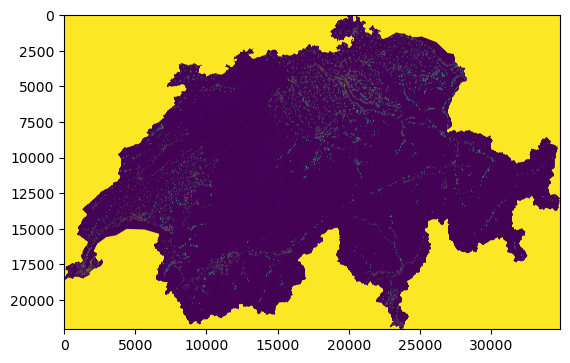

In [ ]:
plt.imshow(habitat)